# Keras CIFAR10 CNN

In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                                                                        
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);

var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)


<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
css = '''
div.cell {background-color: #feddef;}
'''
HTML(css)
display(HTML("<style>" + css + "</style>"))

In [3]:
import _pickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename, astype='float'):
  """ load single batch of cifar """
  print(filename)
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype(astype)
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT, n=1, astype='float'):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1, n+1):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f, astype=astype)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  # Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'), astype=astype)
  return Xtr, Ytr, # Xte, Yte


def get_CIFAR10_data(num_training=17000, num_validation=1000,
                     num_test=2000, astype='float'):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    import math
    cifar10_dir = '../CS231n_assignment2/cs231n/datasets'
    n = math.ceil((num_training + num_validation + num_test) / 10000)
    X_train, y_train = load_CIFAR10(cifar10_dir, n=int(n), astype=astype)

    # Subsample the data
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    mask = list(mask)
    X_test = X_train[mask]
    y_test = y_train[mask]

    mask = range(num_training, num_training + num_validation)
    mask = list(mask)
    X_val = X_train[mask]
    y_val = y_train[mask]

    mask = range(num_training)
    mask = list(mask)
    X_train = X_train[mask]
    y_train = y_train[mask]

    print('X_train', X_train.shape)
    print('X_val', X_val.shape)
    print('X_test', X_test.shape)
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Transpose so that channels come first
    # Probe: on keras tf maybe no need
#     X_train = X_train.transpose(0, 3, 1, 2).copy()
#     X_val = X_val.transpose(0, 3, 1, 2).copy()
#     X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }


# data = get_CIFAR10_data(num_training=17000, num_validation=1000,
#                         num_test=2000, astype='float')
data = get_CIFAR10_data(num_training=19000, num_validation=1000,
                        num_test=0, astype=np.float32)

for k, v in data.items():
  print ('%s: ' % k, v.shape)

../CS231n_assignment2/cs231n/datasets\data_batch_1
../CS231n_assignment2/cs231n/datasets\data_batch_2
X_train (19000, 32, 32, 3)
X_val (1000, 32, 32, 3)
X_test (0, 32, 32, 3)
X_train:  (19000, 32, 32, 3)
y_test:  (0,)
X_test:  (0, 32, 32, 3)
y_val:  (1000,)
X_val:  (1000, 32, 32, 3)
y_train:  (19000,)


In [5]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
GPU run command with Theano backend (with TensorFlow, the GPU is automatically used):
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python cifar10_cnn.py
It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).
'''

# from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [6]:

nb_classes = 10

# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

# The data, shuffled and split between train and test sets:
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()
# X_train = small_data['X_train']
# y_train = small_data['y_train']
# X_test = small_data['X_val']
# y_test = small_data['y_val']
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_val']
y_test = data['y_val']

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# print(Y_train)
# print(Y_test)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

X_train shape: (19000, 32, 32, 3)
19000 train samples
1000 test samples


In [7]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
[(k, v.shape) for k,v in small_data.items()]

[('X_train', (100, 32, 32, 3)),
 ('X_val', (1000, 32, 32, 3)),
 ('y_train', (100,)),
 ('y_val', (1000,))]

In [9]:

# conv - relu - 2x2 max pool - affine - relu - affine - softmax
#     N, C, H, W = X.shape
#     crp_out, crp_cache = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param)
#     N, F, Hout, Wout = crp_out.shape
#     crp_out = crp_out.reshape((N, -1))  # N, F, Hout, Wout -> N, F*Hout*Wout
#     hidden_out, hidden_cache = affine_relu_forward(crp_out, W2, b2)
#     scores, scores_cache = affine_forward(hidden_out, W3, b3)

# def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
#              hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
  
#     conv_param = {'stride': 1, 'pad': int((filter_size - 1) / 2)}
#     pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}


model = Sequential()

model.add(Convolution2D(32, 7, 7, border_mode='same',
                        input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

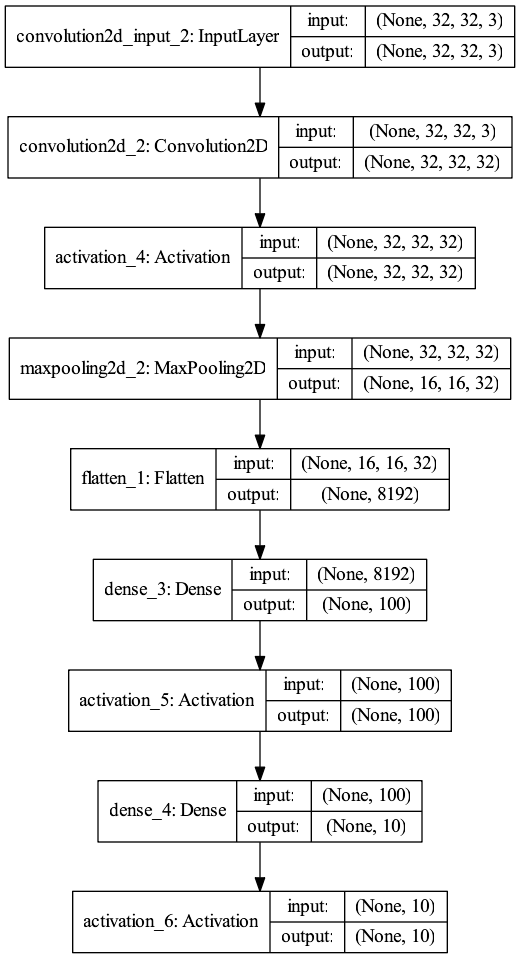

In [10]:
from keras.utils.visualize_util import plot
plot(model, show_shapes=True, to_file='model.png')
# plot?
from IPython.display import display, Image
display(Image('model.png', width=500))
# display(Image('model.png'))

In [17]:
batch_size = 100
nb_epoch = 2
data_augmentation = False
if not data_augmentation:
    print('Not using data augmentation.')
    hist = model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True,
              verbose=2, 
              )
    
    
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

#     # Compute quantities required for featurewise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(X_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(X_train, Y_train,
#                                      batch_size=batch_size),
#                         samples_per_epoch=X_train.shape[0],
#                         nb_epoch=nb_epoch,
#                         validation_data=(X_test, Y_test))

Not using data augmentation.
Train on 19000 samples, validate on 1000 samples
Epoch 1/2
19000/19000 [==============================] - 65s - loss: 0.5523 - acc: 0.8101 - val_loss: 1.2530 - val_acc: 0.6150

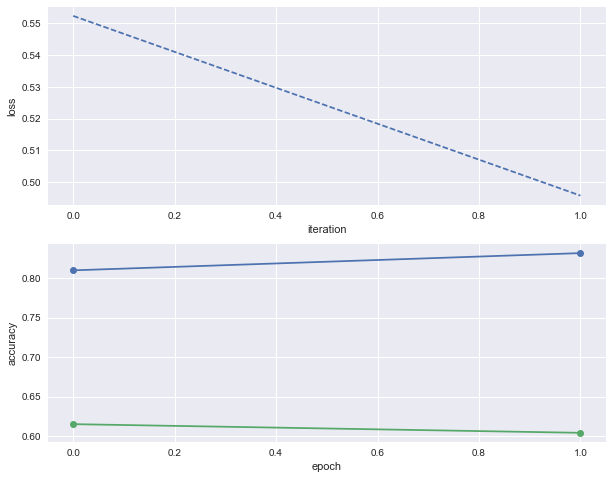

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# print(help(hist))
plt.subplot(2, 1, 1)
plt.plot(hist.history['loss'], '--')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist.history['acc'], '-o')
plt.plot(hist.history['val_acc'], '-o')
# plt.plot(solver.val_acc_history, '-o')
# plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()